# Part 1: Vehicle Loading/Unloading Analysis

This notebook calculates and prints loading and unloading man-hours for each vehicle type. Adjust parameters at the top as needed.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import minimize

In [2]:
# 1. Vehicle data and benchmarks
VEHICLES = [
    {"type": "50 ft ODC Trailer / Container", "L": 50, "parcels": 1500},
    {"type": "32 ft Container MXL",           "L": 32, "parcels": 1000},
    {"type": "32 ft Container SXL",           "L": 32, "parcels": 700},
    {"type": "24 ft Box/Container Truck",     "L": 24, "parcels": 600},
    {"type": "Tata 22 ft Container",          "L": 22, "parcels": 600},
    {"type": "Eicher 19 ft",                  "L": 19, "parcels": 500},
    {"type": "Eicher 17 ft",                  "L": 17, "parcels": 425},
    {"type": "Eicher 14 ft (LCV)",            "L": 14, "parcels": 300},
    {"type": "Tata 407 / Dost Bada",          "L": 10, "parcels": 215},
    {"type": "Mahindra Bolero Pickup",        "L": 9,  "parcels": 100},
    {"type": "Tata Ace / Dost",               "L": 8,  "parcels": 50},
]

opt_loading = {
    "50 ft ODC Trailer / Container": 24,
    "32 ft Container MXL": 15,
    "32 ft Container SXL": 9,
    "24 ft Box/Container Truck": 9,
    "Tata 22 ft Container": 6.125,
    "Eicher 19 ft": 4.5,
    "Eicher 17 ft": 2.8125,
    "Eicher 14 ft (LCV)": 2.1875,
    "Tata 407 / Dost Bada": 1.875,
    "Mahindra Bolero Pickup": 0.825,
    "Tata Ace / Dost": 0.525
}

opt_unloading = {
    "50 ft ODC Trailer / Container": 19.5,
    "32 ft Container MXL": 12.5,
    "32 ft Container SXL": 7,
    "24 ft Box/Container Truck": 7,
    "Tata 22 ft Container": 4.8125,
    "Eicher 19 ft": 3.75,
    "Eicher 17 ft": 2.1875,
    "Eicher 14 ft (LCV)": 1.625,
    "Tata 407 / Dost Bada": 1.375,
    "Mahindra Bolero Pickup": 0.6,
    "Tata Ace / Dost": 0.3
}

## A) Locally Optimized Parameters

▶ Optimized parameters:
  f1 (≤100 parcels):     ×1.394
  f2 (≤200 parcels):     ×1.200
  f3 (≤300 parcels):     ×1.115
  f4 (>300 parcels):     ×1.095
  Length factor α:       ×0.927
  Turning time tturn:    0.500 s/parcel
  Mean‐squared %‐error:  0.031762

=== Error Table ===


,Vehicle,Opt Load (h),Calc Load (h),Err Load (%),Opt Unld (h),Calc Unld (h),Err Unld (%)
0,50 ft ODC Trailer / Container,24.0000,23.31,2.9,19.5000,21.67,11.1
1,32 ft Container MXL,15.0000,11.51,23.3,12.5000,10.42,16.7
2,32 ft Container SXL,9.0000,8.06,10.5,7.0000,7.29,4.2
3,24 ft Box/Container Truck,9.0000,5.83,35.2,7.0000,5.18,26.0
4,Tata 22 ft Container,6.1250,5.56,9.2,4.8125,4.91,2.0
5,Eicher 19 ft,4.5000,4.30,4.4,3.7500,3.75,0.1
6,Eicher 17 ft,2.8125,3.47,23.2,2.1875,3.00,37.2
7,Eicher 14 ft (LCV),2.1875,2.28,4.4,1.6250,1.95,20.1
8,Tata 407 / Dost Bada,1.8750,1.44,23.1,1.3750,1.20,12.5
9,Mahindra Bolero Pickup,0.8250,0.81,1.8,0.6000,0.67,11.8



=== Manual vs Machine Table ===


,Vehicle,Manual Load (h),Machine Load (h),% Save Load,Manual Unld (h),Machine Unld (h),% Save Unld
0,50 ft ODC Trailer / Container,23.31,5.96,74.4,21.67,4.46,79.4
1,32 ft Container MXL,11.51,3.97,65.5,10.42,2.98,71.4
2,32 ft Container SXL,8.06,2.78,65.5,7.29,2.08,71.4
3,24 ft Box/Container Truck,5.83,2.38,59.1,5.18,1.78,65.5
4,Tata 22 ft Container,5.56,2.38,57.2,4.91,1.78,63.6
5,Eicher 19 ft,4.30,1.99,53.8,3.75,1.49,60.4
6,Eicher 17 ft,3.47,1.69,51.3,3.00,1.26,57.9
7,Eicher 14 ft (LCV),2.28,1.19,47.8,1.95,0.89,54.3
8,Tata 407 / Dost Bada,1.44,0.85,40.8,1.20,0.64,46.8
9,Mahindra Bolero Pickup,0.81,0.40,51.0,0.67,0.30,55.7


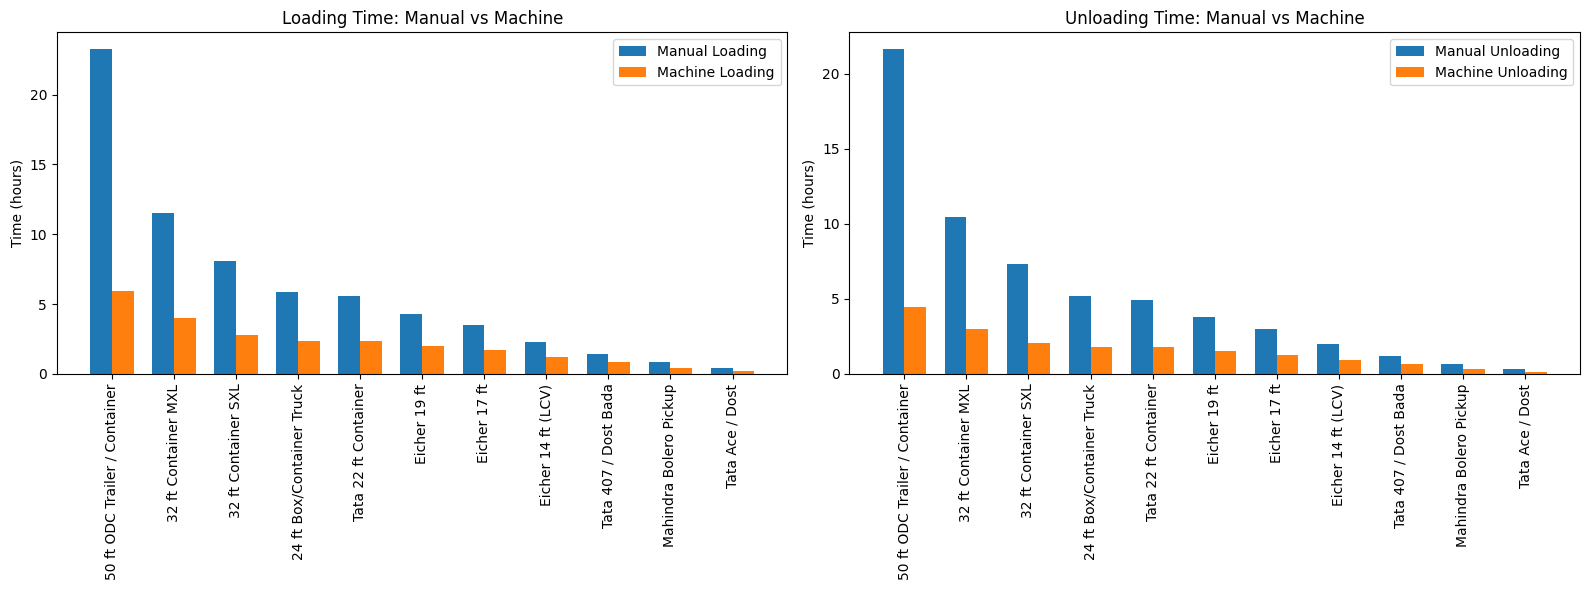

In [3]:
# 2. Constants
SPEED_WITHOUT_LOAD = 0.9   # m/s
SPEED_WITH_LOAD    = 0.67  # m/s
LOADING_DELAY      = 13.8  # s/parcel
UNLOADING_DELAY    = 10.21 # s/parcel

# 3. Compute times given parameters [f1,f2,f3,f4, alpha, tturn]
def compute_times(params):
    f1, f2, f3, f4, alpha, tturn = params
    manual_load, manual_unld = [], []
    machine_load, machine_unld = [], []
    
    for v in VEHICLES:
        n, L_ft = v['parcels'], v['L']
        # fatigue multiplier
        if   n <= 100: fm = f1
        elif n <= 200: fm = f2
        elif n <= 300: fm = f3
        else:           fm = f4

        # walking distance (m)
        d = L_ft * 0.3048 * alpha
        # walking time (hr)
        walk_hr = ((d / SPEED_WITHOUT_LOAD) + (d / SPEED_WITH_LOAD)) * n * fm / 3600
        # handling time (hr)
        load_hr = (LOADING_DELAY + tturn)   * n * fm / 3600
        unld_hr = (UNLOADING_DELAY + tturn) * n * fm / 3600
        # machine times (hr)
        machL = (LOADING_DELAY + tturn)   * n / 3600
        machU = (UNLOADING_DELAY + tturn) * n / 3600

        manual_load.append(walk_hr + load_hr)
        manual_unld.append(walk_hr + unld_hr)
        machine_load.append(machL)
        machine_unld.append(machU)
    
    return (np.array(manual_load),
            np.array(manual_unld),
            np.array(machine_load),
            np.array(machine_unld))

# 4. Loss function
def loss(params):
    mL, mU, _, _ = compute_times(params)
    errs = []
    for v, pL, pU in zip(VEHICLES, mL, mU):
        lbl = v['type']
        errs.append((pL - opt_loading[lbl])   / opt_loading[lbl])
        errs.append((pU - opt_unloading[lbl]) / opt_unloading[lbl])
    return np.mean(np.square(errs))

# 5. Optimize parameters
initial = [1.1, 1.2, 1.3, 1.4, 0.6, 2.0]  # f1,f2,f3,f4,alpha,tturn
bounds = [(1,2)]*4 + [(0.3,1.0), (0.5,5.0)]
res = minimize(loss, initial, bounds=bounds, method='L-BFGS-B')
f1, f2, f3, f4, alpha, tturn = res.x

print("▶ Optimized parameters:")
print(f"  f1 (≤100 parcels):     ×{f1:.3f}")
print(f"  f2 (≤200 parcels):     ×{f2:.3f}")
print(f"  f3 (≤300 parcels):     ×{f3:.3f}")
print(f"  f4 (>300 parcels):     ×{f4:.3f}")
print(f"  Length factor α:       ×{alpha:.3f}")
print(f"  Turning time tturn:    {tturn:.3f} s/parcel")
print(f"  Mean‐squared %‐error:  {res.fun:.6f}\n")

# 6. Recompute times
mL, mU, machL, machU = compute_times([f1, f2, f3, f4, alpha, tturn])

# 7. Build Error Table
error_rows = []
for v, pL, pU in zip(VEHICLES, mL, mU):
    lbl = v['type']
    optL, optU = opt_loading[lbl], opt_unloading[lbl]
    error_rows.append({
        "Vehicle": lbl,
        "Opt Load (h)": optL,
        "Calc Load (h)": round(pL,2),
        "Err Load (%)": round(abs(pL-optL)/optL*100,1),
        "Opt Unld (h)": optU,
        "Calc Unld (h)": round(pU,2),
        "Err Unld (%)": round(abs(pU-optU)/optU*100,1),
    })
error_df = pd.DataFrame(error_rows)

from IPython.display import display

print("=== Error Table ===")
display(error_df)

# 8. Build Manual vs Auto Table
ma_rows = []
for v, pL, pU, ML, MU in zip(VEHICLES, mL, mU, machL, machU):
    lbl = v['type']
    ma_rows.append({
        "Vehicle": lbl,
        "Manual Load (h)": round(pL,2),
        "Machine Load (h)": round(ML,2),
        "% Save Load": round(100*(1-ML/pL),1),
        "Manual Unld (h)": round(pU,2),
        "Machine Unld (h)": round(MU,2),
        "% Save Unld": round(100*(1-MU/pU),1)
    })
ma_df = pd.DataFrame(ma_rows)

print("\n=== Manual vs Machine Table ===")
display(ma_df)

# 9. Plotting
x = np.arange(len(VEHICLES))
width = 0.35

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,6))

# Loading plot
ax1.bar(x - width/2, mL, width, label="Manual Loading")
ax1.bar(x + width/2, machL, width, label="Machine Loading")
ax1.set_xticks(x)
ax1.set_xticklabels([v['type'] for v in VEHICLES], rotation=90)
ax1.set_ylabel("Time (hours)")
ax1.set_title("Loading Time: Manual vs Machine")
ax1.legend()

# Unloading plot
ax2.bar(x - width/2, mU, width, label="Manual Unloading")
ax2.bar(x + width/2, machU, width, label="Machine Unloading")
ax2.set_xticks(x)
ax2.set_xticklabels([v['type'] for v in VEHICLES], rotation=90)
ax2.set_ylabel("Time (hours)")
ax2.set_title("Unloading Time: Manual vs Machine")
ax2.legend()

plt.tight_layout()
plt.show()

## B) Globally and Locally Optimized Parameters

▶ Optimized parameters:
  f1–f4: 1.296, 1.200, 1.008, 1.029
  α (length factor): 0.830
  tturn (s): 1.879
  v_walk, v_load (m/s): 0.830, 0.534
  d_load, d_unld (s): 13.96, 9.93
  Mean‐squared %‐error: 0.031819

=== Error Table ===


,Vehicle,Opt Load (h),Calc Load (h),Err Load (%),Opt Unld (h),Calc Unld (h),Err Unld (%)
0,50 ft ODC Trailer / Container,24.0000,23.47,2.2,19.5000,21.75,11.5
1,32 ft Container MXL,15.0000,11.64,22.4,12.5000,10.49,16.1
2,32 ft Container SXL,9.0000,8.15,9.4,7.0000,7.35,4.9
3,24 ft Box/Container Truck,9.0000,5.92,34.2,7.0000,5.23,25.3
4,Tata 22 ft Container,6.1250,5.65,7.7,4.8125,4.96,3.1
5,Eicher 19 ft,4.5000,4.38,2.8,3.7500,3.80,1.4
6,Eicher 17 ft,2.8125,3.53,25.5,2.1875,3.04,39.0
7,Eicher 14 ft (LCV),2.1875,2.25,2.6,1.6250,1.91,17.4
8,Tata 407 / Dost Bada,1.8750,1.42,24.2,1.3750,1.18,14.2
9,Mahindra Bolero Pickup,0.8250,0.82,0.4,0.6000,0.68,12.9



=== Manual vs Machine Table ===


,Vehicle,Manual Load (h),Machine Load (h),% Save Load,Manual Unld (h),Machine Unld (h),% Save Unld
0,50 ft ODC Trailer / Container,23.47,6.60,71.9,21.75,4.92,77.4
1,32 ft Container MXL,11.64,4.40,62.2,10.49,3.28,68.7
2,32 ft Container SXL,8.15,3.08,62.2,7.35,2.30,68.7
3,24 ft Box/Container Truck,5.92,2.64,55.4,5.23,1.97,62.3
4,Tata 22 ft Container,5.65,2.64,53.3,4.96,1.97,60.3
5,Eicher 19 ft,4.38,2.20,49.7,3.80,1.64,56.8
6,Eicher 17 ft,3.53,1.87,47.0,3.04,1.39,54.2
7,Eicher 14 ft (LCV),2.25,1.32,41.2,1.91,0.98,48.4
8,Tata 407 / Dost Bada,1.42,0.95,33.5,1.18,0.71,40.2
9,Mahindra Bolero Pickup,0.82,0.44,46.5,0.68,0.33,51.6


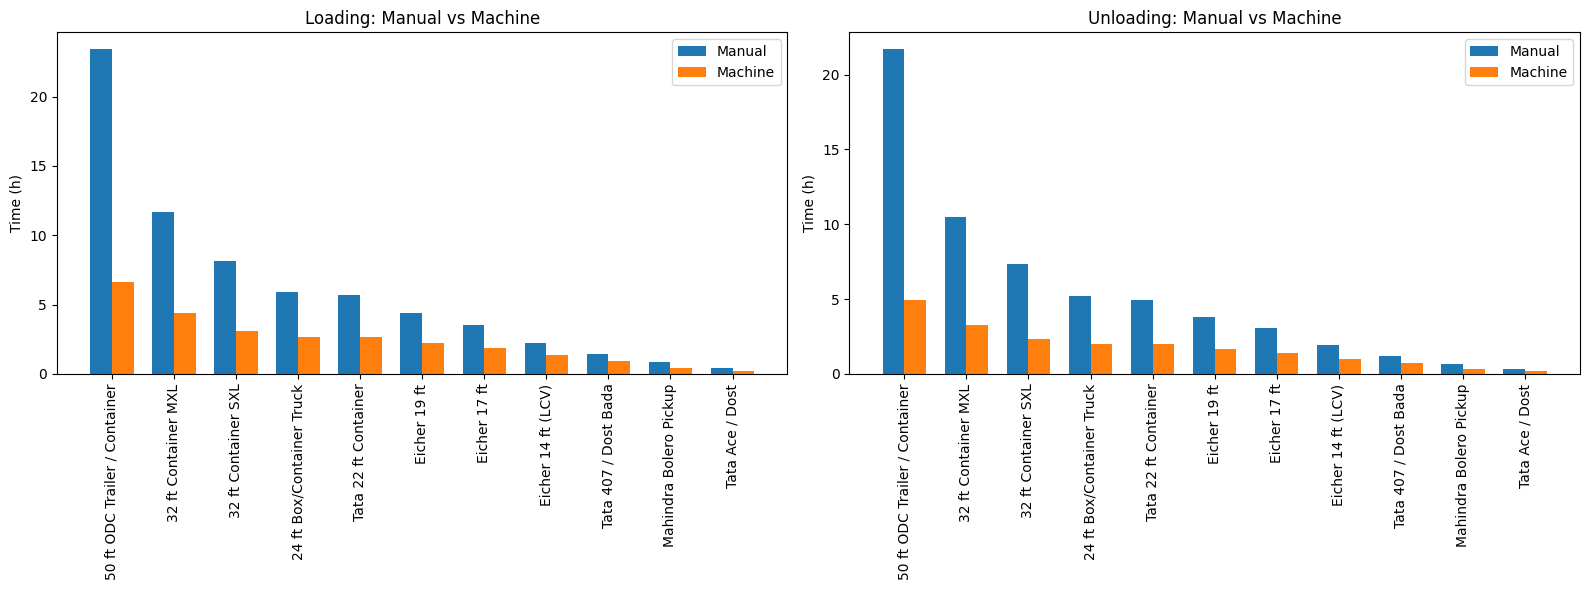

In [4]:
# 2. Compute times given all parameters as variables:
# params = [f1,f2,f3,f4, alpha, tturn, v_walk, v_load, delay_load, delay_unld]
def compute_times(params):
    f1, f2, f3, f4, alpha, tturn, v_walk, v_load, d_load, d_unld = params
    manual_load, manual_unld = [], []
    machine_load, machine_unld = [], []
    for v in VEHICLES:
        n, L_ft = v['parcels'], v['L']
        fm = f1 if n<=100 else f2 if n<=200 else f3 if n<=300 else f4
        d = L_ft * 0.3048 * alpha
        walk_hr = ((d/v_walk) + (d/v_load)) * n * fm / 3600
        load_hr = (d_load + tturn)   * n * fm / 3600
        unld_hr = (d_unld + tturn)  * n * fm / 3600
        machL = (d_load + tturn)   * n / 3600
        machU = (d_unld + tturn)   * n / 3600
        manual_load.append(walk_hr + load_hr)
        manual_unld.append(walk_hr + unld_hr)
        machine_load.append(machL)
        machine_unld.append(machU)
    return (np.array(manual_load),
            np.array(manual_unld),
            np.array(machine_load),
            np.array(machine_unld))

# 3. Loss = mean squared percentage error vs benchmarks
def loss(params):
    mL, mU, _, _ = compute_times(params)
    errs = []
    for v, pL, pU in zip(VEHICLES, mL, mU):
        lbl = v['type']
        errs.append((pL - opt_loading[lbl])   / opt_loading[lbl])
        errs.append((pU - opt_unloading[lbl]) / opt_unloading[lbl])
    return np.mean(np.square(errs))

# 4. Optimize all parameters
initial = [
    1.1, 1.2, 1.3, 1.4,    # f1–f4
    0.6,                   # alpha
    2.0,                   # tturn
    0.9,                   # v_walk
    0.67,                  # v_load
    13.8,                  # d_load
    10.21                  # d_unld
]
bounds = [
    (1.0, 2.0), (1.0, 2.0), (1.0, 2.0), (1.0, 2.0),  # f1–f4
    (0.3, 1.0),        # alpha
    (0.5, 5.0),        # tturn
    (0.5, 2.0),        # v_walk
    (0.3, 1.5),        # v_load
    (5.0, 20.0),       # d_load
    (5.0, 20.0)        # d_unld
]
res = minimize(loss, initial, bounds=bounds, method='L-BFGS-B')
f1,f2,f3,f4,alpha,tturn,v_walk,v_load,d_load,d_unld = res.x

print("▶ Optimized parameters:")
print(f"  f1–f4: {f1:.3f}, {f2:.3f}, {f3:.3f}, {f4:.3f}")
print(f"  α (length factor): {alpha:.3f}")
print(f"  tturn (s): {tturn:.3f}")
print(f"  v_walk, v_load (m/s): {v_walk:.3f}, {v_load:.3f}")
print(f"  d_load, d_unld (s): {d_load:.2f}, {d_unld:.2f}")
print(f"  Mean‐squared %‐error: {res.fun:.6f}\n")

# 5. Recompute with optimized params
mL, mU, machL, machU = compute_times(res.x)

# 6. Error Table
err_rows = []
for v, pL, pU in zip(VEHICLES, mL, mU):
    lbl = v['type']
    err_rows.append({
        "Vehicle": lbl,
        "Opt Load (h)": opt_loading[lbl],
        "Calc Load (h)": round(pL,2),
        "Err Load (%)": round(abs(pL-opt_loading[lbl])/opt_loading[lbl]*100,1),
        "Opt Unld (h)": opt_unloading[lbl],
        "Calc Unld (h)": round(pU,2),
        "Err Unld (%)": round(abs(pU-opt_unloading[lbl])/opt_unloading[lbl]*100,1)
    })
error_df = pd.DataFrame(err_rows)
print("=== Error Table ===")
display(error_df)

# 7. Manual vs Machine Table
ma_rows = []
for v, pL, pU, ML, MU in zip(VEHICLES, mL, mU, machL, machU):
    lbl = v['type']
    ma_rows.append({
        "Vehicle": lbl,
        "Manual Load (h)": round(pL,2),
        "Machine Load (h)": round(ML,2),
        "% Save Load": round(100*(1-ML/pL),1),
        "Manual Unld (h)": round(pU,2),
        "Machine Unld (h)": round(MU,2),
        "% Save Unld": round(100*(1-MU/pU),1)
    })
ma_df = pd.DataFrame(ma_rows)
print("\n=== Manual vs Machine Table ===")
display(ma_df)

# 8. Plotting
x = np.arange(len(VEHICLES))
w = 0.35
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(16,6))

# Loading
ax1.bar(x-w/2, mL, w, label="Manual")
ax1.bar(x+w/2, machL, w, label="Machine")
ax1.set_xticks(x); ax1.set_xticklabels([v['type'] for v in VEHICLES], rotation=90)
ax1.set_ylabel("Time (h)")
ax1.set_title("Loading: Manual vs Machine")
ax1.legend()

# Unloading
ax2.bar(x-w/2, mU, w, label="Manual")
ax2.bar(x+w/2, machU, w, label="Machine")
ax2.set_xticks(x); ax2.set_xticklabels([v['type'] for v in VEHICLES], rotation=90)
ax2.set_ylabel("Time (h)")
ax2.set_title("Unloading: Manual vs Machine")
ax2.legend()

plt.tight_layout()
plt.show()

# Part 2: Budget & Break-even Feasibility Analysis

In [5]:
manual_cost_per_hour = 75     # INR per worker per hour
workers_per_trip = 4           # typical team size

machine_cost = {
    "capex": 700000,          # INR
    "opex_per_hour": 500,      # machine operation cost per hour
    "life_years": 10,
    "daily_hours": 20           # usage per day
}

# Build cost-benefit table
break_even_rows = []
for i, v in enumerate(VEHICLES):
    name = v["type"]

    # Total manual time and cost per trip
    man_time = mL[i] + mU[i]
    man_cost = man_time * manual_cost_per_hour * workers_per_trip

    # Total machine time and cost per trip
    mach_time = machL[i] + machU[i]
    mach_cost = mach_time * machine_cost["opex_per_hour"]

    # Trip-level savings
    savings_per_trip = man_cost - mach_cost
    trips_per_day = int(machine_cost["daily_hours"] // mach_time)
    daily_savings = savings_per_trip * trips_per_day
    break_even_days = machine_cost["capex"] / daily_savings if daily_savings > 0 else float('inf')

    break_even_rows.append({
        "Vehicle": name,
        "Manual Cost/trip (₹)": round(man_cost, 1),
        "Machine Cost/trip (₹)": round(mach_cost, 1),
        "Savings/trip (₹)": round(savings_per_trip, 1),
        "Trips/day": trips_per_day,
        "Daily Savings (₹)": round(daily_savings, 1),
        "Break-even (days)": round(break_even_days, 1) if daily_savings > 0 else "No Savings"
    })

# Convert to DataFrame
be_df = pd.DataFrame(break_even_rows)

print("=== Budget & Break-even Analysis ===")
display(be_df)

=== Budget & Break-even Analysis ===


,Vehicle,Manual Cost/trip (₹),Machine Cost/trip (₹),Savings/trip (₹),Trips/day,Daily Savings (₹),Break-even (days)
0,50 ft ODC Trailer / Container,13565.4,5759.6,7805.9,1,7805.9,89.7
1,32 ft Container MXL,6641.1,3839.7,2801.4,2,5602.7,124.9
2,32 ft Container SXL,4648.8,2687.8,1960.9,3,5882.8,119.0
3,24 ft Box/Container Truck,3344.0,2303.8,1040.1,4,4160.5,168.2
4,Tata 22 ft Container,3183.8,2303.8,880.0,4,3519.8,198.9
5,Eicher 19 ft,2453.0,1919.9,533.1,5,2665.4,262.6
6,Eicher 17 ft,1971.6,1631.9,339.7,6,2038.0,343.5
7,Eicher 14 ft (LCV),1245.7,1151.9,93.8,8,750.4,932.9
8,Tata 407 / Dost Bada,780.3,825.5,-45.2,12,-542.8,No Savings
9,Mahindra Bolero Pickup,449.8,384.0,65.8,26,1710.6,409.2


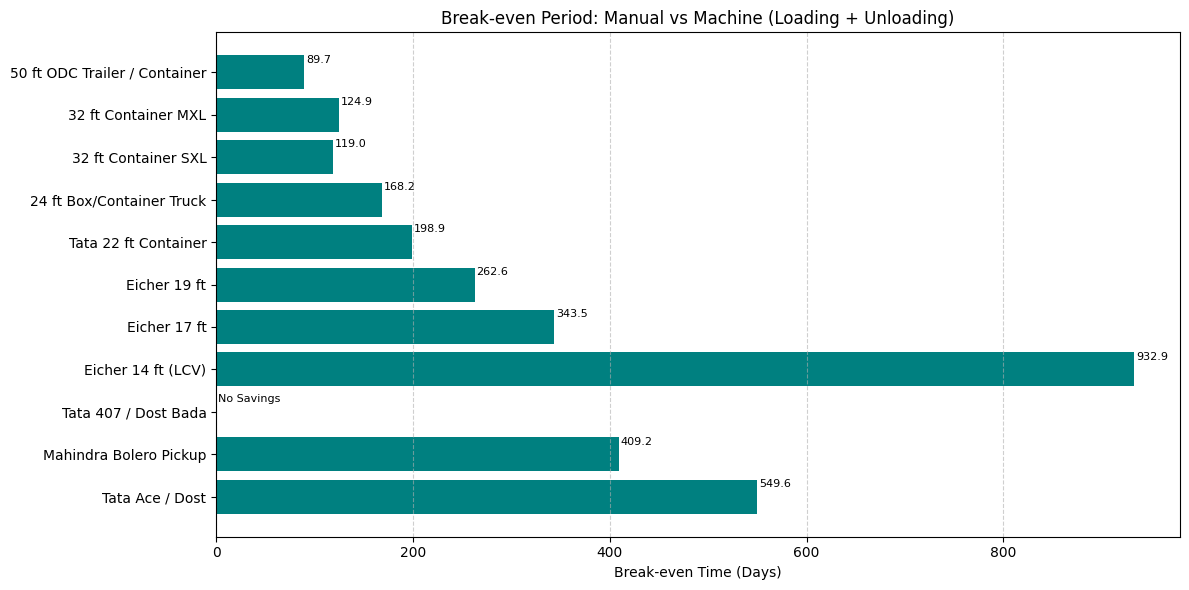

In [6]:
# Bar plot of break-even times
plt.figure(figsize=(12, 6))
vehicles = be_df["Vehicle"]
break_even_vals = [val if isinstance(val, (float, int)) else 0 for val in be_df["Break-even (days)"]]
colors = ["gray" if val == 0 else "teal" for val in break_even_vals]

bars = plt.barh(vehicles, break_even_vals, color=colors)
plt.xlabel("Break-even Time (Days)")
plt.title("Break-even Period: Manual vs Machine (Loading + Unloading)")
plt.gca().invert_yaxis()
plt.grid(True, axis='x', linestyle='--', alpha=0.6)

# Label bars
for bar, val in zip(bars, be_df["Break-even (days)"]):
    label = str(val) if isinstance(val, (float, int)) else "No Savings"
    plt.text(bar.get_width() + 2, bar.get_y() + 0.1, label, va='center', fontsize=8)

plt.tight_layout()
plt.show()